# CBRS

In [1]:
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
JSON_DATA_PATH = "/Users/tural/Downloads/reviews_Digital_Music_5.json"
N = 10

In [3]:
import json

def iter_json_data(path):
    with open(path) as f:
        for line in f:
            data = json.loads(line)
            yield data
            
def get_data_frame():
    uid_to_id = {}
    iid_to_id = {}
    
    cols = ["uid", "iid", "review", "rating", "dt"]
    rows = []
    for d in iter_json_data(JSON_DATA_PATH):
        uid = uid_to_id.setdefault(d["reviewerID"], len(uid_to_id))
        iid = iid_to_id.setdefault(d["asin"], len(iid_to_id))
        review = d["reviewText"]
        rating = float(d["overall"])
        dt = int(d["unixReviewTime"])
        rows.append((uid, iid, review, rating, dt))
        
    return pd.DataFrame(rows, columns=cols)

In [4]:
df = get_data_frame()
df.head()

,uid,iid,review,rating,dt
0,0,0,"It's hard to believe ""Memory of Trees"" came ou...",5.0,1158019200
1,1,0,"A clasically-styled and introverted album, Mem...",5.0,991526400
2,2,0,I never thought Enya would reach the sublime h...,5.0,1058140800
3,3,0,This is the third review of an irish album I w...,5.0,957312000
4,4,0,"Enya, despite being a successful recording art...",4.0,1200528000


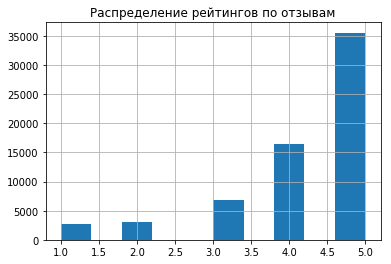

In [5]:
plt.title("Распределение рейтингов по отзывам")
df.rating.hist()

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
review_ftr_m = TfidfVectorizer(stop_words='english').fit_transform(df.review)

In [10]:
# сразу умножаем на рейтинги
review_ftr_m = review_ftr_m.multiply(df.rating.values.reshape(-1, 1)).tocsr()

In [13]:
from sklearn.preprocessing import normalize
from scipy.sparse import vstack

def _prepare_iid_data(df, review_ftr_m): 
    iid_to_row = {}
    rows = []
    # не самый оптимальный group by       
    for row_id, iid in enumerate(df.iid.unique()):
        iid_to_row[iid] = row_id
        iid_ftr_m = csr_matrix(
            review_ftr_m[np.where(df.iid == iid)[0]].sum(axis=0)
        )
        rows.append(iid_ftr_m)
    iid_ftr_m = normalize(vstack(rows, format='csr'))
    return iid_to_row, iid_ftr_m

In [15]:
iid_to_row, iid_ftr_m = _prepare_iid_data(df, review_ftr_m)

In [16]:
def _prepare_uid_data(df, iid_to_row, iid_ftr_m):  
        uid_to_row = {}
        rows = []
        
        # gr_df - кусок df с данными одного пользователя 
        for gr_id, gr_df in df.groupby("uid"):
            uid = gr_df.uid.values[0]
            
            # поиск объектов и пользовательских рейтингов для них
            iid_rows = []
            ratings = []
            for iid, rating in zip(gr_df.iid.values, gr_df.rating.values):
                if iid in iid_to_row:
                    iid_rows.append(iid_to_row[iid])
                    ratings.append(rating)
                  
            # создание профиля пользователя
            if iid_rows:
                ratings = np.array(ratings).reshape(-1, 1)
                uid_ftr_m = csr_matrix(
                    iid_ftr_m[iid_rows].multiply(ratings).sum(axis=0)
                ) 
                uid_to_row[uid] = len(uid_to_row)
                rows.append(uid_ftr_m)
            
        uid_ftr_m = normalize(vstack(rows, format='csr'))
        return uid_to_row, uid_ftr_m

In [17]:
uid_to_row, uid_ftr_m = _prepare_uid_data(df, iid_to_row, iid_ftr_m)

In [21]:
# немного упрощаем себе жизнь (для подсчета рекомендаций с использованием косинусной меры)
ftr_iid_m = iid_ftr_m.T.tocsr()
row_to_iid = {row_id: iid for iid, row_id in iid_to_row.items()}

In [22]:
def get_recs(uid, top=N):
    recs = {}
    if uid in uid_to_row:
        u_row_id = uid_to_row[uid]
        u_row = uid_ftr_m[u_row_id]

        # самописный cosine similarity
        u_recs = u_row.dot(ftr_iid_m)

        for arg_id in np.argsort(u_recs.data)[-top:]:
            row_id = u_recs.indices[arg_id]
            score = u_recs.data[arg_id]
            recs[row_to_iid[row_id]] = score
    return recs

In [23]:
get_recs(1)

{100: 0.56170351921254102,
 660: 0.61231096193093804,
 667: 0.65325302417319553,
 825: 0.60523739638417229,
 1118: 0.58343909272142236,
 1278: 0.56440352770364166,
 1279: 0.54976944847729181,
 1281: 0.61996582908664999,
 1714: 0.56878258215043809,
 2246: 0.54570034527534084}